<a href="https://colab.research.google.com/github/hu1q1/AudioSet/blob/main/AudioSet_IT1244.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial Setup
You need to first run this pip install command to upgrade the tensorflow version. This notebook requires Tensorflow 2.10

**Restart your runtime after installation when prompted by the output**

In [ ]:
!pip install tensorflow==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 19 kB/s 
     |████████████████████████████████| 1.7 MB 38.8 MB/s 
     |████████████████████████████████| 438 kB 47.2 MB/s 
     |████████████████████████████████| 5.9 MB 42.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully u

## Audio Dataset Example

https://www.tensorflow.org/tutorials/audio/simple_audio

The following chunks of code perform
- Data Ingest & Preprocessing
- Model Creation
- Model Training
- Model Evaluation


<hr/>

## Methodology

The data split strategy used is a Train/Validate/Test strategy, following the distribution below

| Data Subset | Percentage | Real Count |
| ----------- | ---------- | ---------- |
| Train       | 90%        | 2700       |
| Validate    | 5%         | 150        |
| Test        | 5%         | 150        |

<hr />



### 1. Ingest the Data

The following code chunk ingests the dataset and performs some preprocessing. This includes converting the audio data to a matrix usable as an input for the ML model.

This only needs to be run once across multiple model runs

In [ ]:
import tensorflow as tf
import pathlib
import numpy as np
import glob
import os
import shutil
import matplotlib.pyplot as plt

from tensorflow.keras import layers as kLayers
from tensorflow.keras import models as kModels

print("TensorFlow version:", tf.__version__)

##################   Downloading the Dataset   ##################
DATASET_PATH = '/content/data/filtered'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
    'audio_dataset.zip',
   origin='https://drive.google.com/uc?export=download&id=1cJnMi4u5AM6an3julR-T0saKUTXSwZ0j',
   extract=True,
    cache_dir='/content', cache_subdir='data'
  )

  os.mkdir('/content/data/filtered')
  for i in range(10):
    os.mkdir('/content/data/filtered/%d' % i)
    files = glob.glob('/content/data/Spoken Digit Dataset/data/%d_*.wav' % i)
    for f in files:
      filename = os.path.basename(f)
      shutil.move(f, ('/content/data/filtered/%d/' % i) + str(filename))

  shutil.rmtree('/content/data/Spoken Digit Dataset')

#####################  Preprocessing Audio  #######################
## Trims clips to 2 seconds
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.1,
    seed=0,
    output_sequence_length=32000,
    subset='both')

label_names = np.array(train_ds.class_names)
print("Labels:", label_names)

def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

print('Done Loading Dataset')

TensorFlow version: 2.10.0
16556965/16556965 [==============================] - 1s 0us/step
Found 3000 files belonging to 10 classes.
Using 2700 files for training.
Using 300 files for validation.
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Done Loading Dataset


### 2. Build the Model
The following code block builds the model based on the declared structure

In [ ]:
for sample_spectrogram, sample_label in train_spectrogram_ds.take(1):
  break
input_shape = sample_spectrogram.shape[1:]
#print(input_shape)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = kLayers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = kModels.Sequential([
    kLayers.Input(shape=input_shape),
    # Downsample the input.
    kLayers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    #kLayers.Conv2D(32, 3, activation='relu'),
    #kLayers.Conv2D(64, 3, activation='relu'),
    #kLayers.MaxPooling2D(),
    #kLayers.Dropout(0.5),
    kLayers.Flatten(),
    kLayers.Dense(128, activation='sigmoid'),
    #kLayers.Dropout(0.5),
    kLayers.Dense(10, activation='softmax'),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_3 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               131200    
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 132,493
Trainable params: 132,490
Non-trainable params: 3
________________________________________________

start of experimenting. first with dnn

In [ ]:
for sample_spectrogram, sample_label in train_spectrogram_ds.take(1):
  break
input_shape = sample_spectrogram.shape[1:]

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = kLayers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = kModels.Sequential([
    kLayers.Input(shape=input_shape),
    # Downsample the input.
    kLayers.Resizing(64, 32),
    kLayers.Flatten(),
    # Normalize.
    #norm_layer,
    kLayers.Dense(2048, activation='relu'),
    kLayers.Dense(2048, activation='relu'),
    kLayers.Dense(88, activation='relu'),
    kLayers.Dropout(0.25),
    kLayers.Dense(256, activation='relu'),
    kLayers.Dense(128, activation='relu'),
    kLayers.Dropout(0.25),
    #kLayers.Conv2D(32, 3, activation='relu'),
    #kLayers.Conv2D(64, 3, activation='relu'),
    #kLayers.MaxPooling2D(),
    #kLayers.Dropout(0.5),
    #kLayers.Dense(128, activation='sigmoid'),
    #kLayers.Dropout(0.5),
    kLayers.Dense(10, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 32, 1)         0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_2 (Dense)             (None, 88)                180312    
                                                                 
 dropout (Dropout)           (None, 88)                0         
                                                                 
 dense_3 (Dense)             (None, 256)               2

now try cnn

In [ ]:
for sample_spectrogram, sample_label in train_spectrogram_ds.take(1):
  break
input_shape = sample_spectrogram.shape[1:]

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = kLayers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = kModels.Sequential([
    kLayers.Input(shape=input_shape),
    # Downsample the input.
    kLayers.Resizing(128, 64),
    # Normalize.
    norm_layer,
    kLayers.Conv2D(64, 6),
    kLayers.Conv2D(44, 3),
    kLayers.MaxPooling2D(),
    kLayers.Dropout(0.5),
    kLayers.Flatten(),
    kLayers.Dense(128, activation='relu'),
    kLayers.Dense(128, activation='sigmoid'),
    kLayers.Dropout(0.5),
    kLayers.Dense(10, activation='softmax'),
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_4 (Resizing)       (None, 128, 64, 1)        0         
                                                                 
 normalization_4 (Normalizat  (None, 128, 64, 1)       3         
 ion)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 123, 59, 64)       2368      
                                                                 
 conv2d_5 (Conv2D)           (None, 121, 57, 44)       25388     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 28, 44)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 60, 28, 44)       

cnn follow architecture 4

In [ ]:
for sample_spectrogram, sample_label in train_spectrogram_ds.take(1):
  break
input_shape = sample_spectrogram.shape[1:]

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = kLayers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = kModels.Sequential([
    kLayers.Input(shape=input_shape),
    # Downsample the input.
    kLayers.Resizing(64, 32),
    # Normalize.
    norm_layer,
    kLayers.Conv2D(64, 6),
    kLayers.Conv2D(44, 3),
    kLayers.MaxPooling2D(),
    kLayers.Dropout(0.5),
    kLayers.Flatten(),
    kLayers.Dense(256, activation='relu'),
    kLayers.Dense(128, activation='relu'),
    kLayers.Dense(64, activation='sigmoid'),
    kLayers.Dropout(0.5),
    kLayers.Dense(10, activation='softmax'),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 64, 32, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 27, 64)        2368      
                                                                 
 conv2d_3 (Conv2D)           (None, 57, 25, 44)        25388     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 12, 44)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 28, 12, 44)        0         
                                                                 
 flatten_1 (Flatten)         (None, 14784)             0         
                                                      

### 3. Training the Model

The following code block trains the model

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
43/43 [==============================] - 129s 3s/step - loss: 2.3803 - accuracy: 0.1467 - val_loss: 1.9890 - val_accuracy: 0.3516
Epoch 2/20
43/43 [==============================] - 129s 3s/step - loss: 2.0193 - accuracy: 0.2707 - val_loss: 1.6342 - val_accuracy: 0.5000
Epoch 3/20
43/43 [==============================] - 129s 3s/step - loss: 1.7404 - accuracy: 0.3667 - val_loss: 1.4149 - val_accuracy: 0.6797
Epoch 4/20
43/43 [==============================] - 128s 3s/step - loss: 1.5451 - accuracy: 0.4404 - val_loss: 1.2409 - val_accuracy: 0.7422
Epoch 5/20
43/43 [==============================] - 133s 3s/step - loss: 1.4129 - accuracy: 0.5015 - val_loss: 1.1628 - val_accuracy: 0.6953
Epoch 6/20
43/43 [==============================] - 129s 3s/step - loss: 1.2956 - accuracy: 0.5559 - val_loss: 1.0564 - val_accuracy: 0.7500
Epoch 7/20
43/43 [==============================] - 129s 3s/step - loss: 1.2158 - accuracy: 0.5700 - val_loss: 0.9816 - val_accuracy: 0.7500
Epoch 8/20
43

### 4. Printing Statistics

The following code block prints the training statistics

Text(0, 0.5, 'Accuracy [%]')

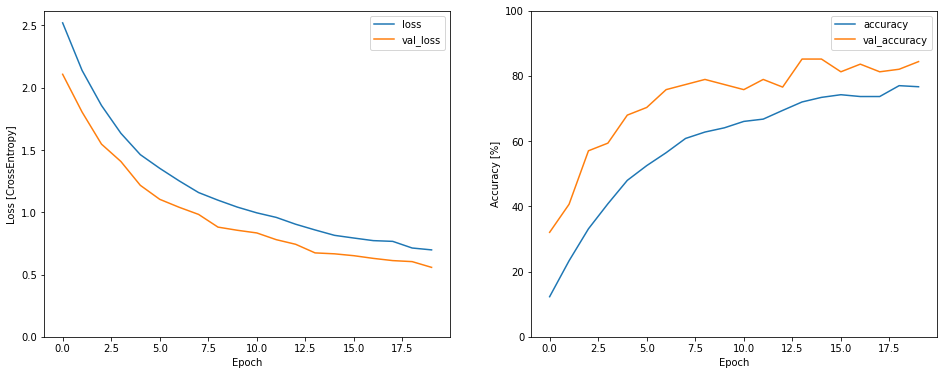

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### 5. Evaluating Model Performance

This evaluates the model on the hold-out test set, which has never been seen during training

In [ ]:
model.evaluate(test_spectrogram_ds)

3/3 [==============================] - 1s 95ms/step - loss: 1.6407 - accuracy: 0.5058


[1.6406612396240234, 0.5058139562606812]

### 6. Save the Model

The following code chunk saves the model

In [ ]:
model.save("output_model")
# The model should be saved to the filesystem